# IMPORTS AND GENERAL FUNCTIONS

In [499]:
# default_exp preprocessing
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime
import glob
import os
import chart_studio.plotly as py
import plotly.graph_objects as go
import missingno as msno
import itertools 
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.ensemble  import RandomForestRegressor

from modules import preprocessing as prep
from modules import data_management as dm
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [500]:
path_base = "./local/data/"

# METEREOLOGICAL DATA

In [550]:
df_dengue_city_week = pd.read_csv(path_base+"prepared_dengue/dengue_weekly_2007_2020.csv", index_col = 0, dtype = {"COD_DPTO":str,"SEMANA":str, "COD_MUNICIPIO":str})
df_dengue_city_week.head(3)

ANO SEMANA COD_MUNICIPIO COD_DPTO  DENGUE  DENGUE GRAVE  \
FECHA                                                                  
2006-12-31  2007     01         91000       91       0             0   
2007-01-07  2007     02         91000       91       0             0   
2007-01-14  2007     03         91000       91       0             0   

            MORTALIDAD POR DENGUE  
FECHA                              
2006-12-31                      0  
2007-01-07                      0  
2007-01-14                      0

# Workflow con datos del mapa del IDEAM

Poner en una única carpeta todos los archivos descargados para una ubicación dada.

Estoy trabajando en lograr que las descargas de la API queden con los mismos campos que las del IDEAM.

Las variables son: 

- "HRA2_AUT_60" <- HUMEDAD RELATIVA A 2 METROS, HORARIA
- "TA2_AUT_60" <- TEMPERATURA A 2 METROS, HORARIA
- "PTPM_CON" <- PRECIPITACIÓN, DIARIA
- "VV_AUT_2" <- VELOCIDAD DLE VIENTO CADA DOS MINUTOS

En todos los casos habrá que combinar datos de varias estaciones, los criterios preferibles son:

1. Correlación (implementación pendiente)
2. Proximidad en altitud (dato solo disponible para las estaciones del mapa del IDEAM)
3. Proximidad en longitud y latitud.

In [551]:
df_cities = dm.read_cities_file()
df_cities

department   municipality   code                  dl_folder  \
0           Antioquia       Medellín  05001              MEDELLIN_DATA   
1           Magdalena    Santa Marta  47001           SANTA_MARTA_DATA   
2           Santander    Bucaramanga  68001           BUCARAMANGA_DATA   
3           Atlántico   Barranquilla  08001  SOLEDAD_BARRANQUILLA_DATA   
4           Atlántico        Soledad  08758  SOLEDAD_BARRANQUILLA_DATA   
5  Norte de Santander         Cúcuta  54001                CUCUTA_DATA   
6     Valle del Cauca           Cali  76001                  CALI_DATA   
7             Caquetá  Villavicencio  50001         VILLAVICENCIO_DATA   

  starting_date         stations_temp          stations_hum  \
0    2012/06/12  [27015330, 27015300]  [27015330, 27015300]   
1    2008/06/25            [15015120]            [15015120]   
2    2014/12/11            [23195230]            [23195230]   
3    2013/05/03  [29045190, 29004520]            [29045190]   
4    2007/01/01                    []                    []   
5    2007/01/01                    []                    []   
6    2007/01/01                    []                    []   
7    2007/01/01                    []                    []   

                    stations_prec stations_rad    range_temp    range_hum  
0  [27015330, 27015290, 27011270]           []  [12.5, 37.5]  [15, 99.99]  
1  [15015050, 15010501, 15015120]           []    [17.5, 40]  [40, 99.99]  
2                      [23195230]           []      [17, 40]  [30, 99.99]  
3  [29045120, 29040450, 29045190]           []      [22, 45]  [45, 99.99]  
4                              []           []            []           []  
5                              []           []      [15, 45]  [30, 99.99]  
6                              []           []      [15, 45]  [30, 99.99]  
7                              []           []            []           []

In [552]:
row_id = 5
params = {}
params_to_get = ["department","municipality","dl_folder","code", "starting_date","stations_temp","stations_hum","stations_prec","stations_rad","range_temp","range_hum"]
params = {param:df_cities.loc[row_id,param] for param in params_to_get}
params

{'department': 'Norte de Santander',
 'municipality': 'Cúcuta',
 'dl_folder': 'CUCUTA_DATA',
 'code': '54001',
 'starting_date': '2007/01/01',
 'stations_temp': [],
 'stations_hum': [],
 'stations_prec': [],
 'stations_rad': [],
 'range_temp': [15, 45],
 'range_hum': [30, 99.99]}

In [553]:
municipality_name = params["municipality"]
cod_municipio = params["code"]
foldername = path_base+"src_per_city/"+params["dl_folder"]
filenames = sorted(glob.glob(foldername+'/*.csv'))
df = prep.read_csv_IDEAM(filenames).drop_duplicates()
df.drop_duplicates(subset=["CodigoEstacion"])

CodigoEstacion                                     NombreEstacion  \
0             16015110  UNIVERSIDAD FRANCISO DE PAULA SANTANDER - AUT ...   
38143         16015501            AEROPUERTO CAMILO DAZA - AUT [16015501]   
117551        16025040                       CINERA-VILLA OLGA [16025040]   
156603        16015010                  AEROPUERTO CAMILO DAZA [16015010]   
158428        16020320                              AGUABLANCA [16020320]   
159914        16020130                               BARRANCAS [16020130]   
161739        16020140                      BOCATOMA RIO ZULIA [16020140]   
163476        16025010                      CARMEN DE TONCHALA [16025010]   
165302        16020180                             CERRO PELAO [16020180]   
168941        16010060                                JARRA LA [16010060]   
170737        16010340                                TASAJERO [16010340]   
172558        16020250                               VACAS LAS [16020250]   
186938        16020340                                PLANADAS [16020340]   
631618        16027280                                   ASTILLEROS - AUT   
637298        16017010                                AGUAS CLARAS  - AUT   

             Latitud   Longitud  Altitud            Categoria  \
0       7.8987777780 -72.487167    311.0  Climática Principal   
38143   7.9316111110 -72.511250    313.0  Sinóptica Principal   
117551  8.1677777780 -72.468611    100.0  Climática Principal   
156603  7.9302777780 -72.509167    250.0  Sinóptica Principal   
158428  8.0361111110 -72.483611    250.0        Pluviométrica   
159914        8.2455 -72.526306     74.0        Pluviométrica   
161739  8.0773333330 -72.583889    150.0        Pluviométrica   
163476  7.8488888890 -72.566111    285.0  Climática Principal   
165302  8.0119444440 -72.500278    300.0        Pluviométrica   
168941  8.2019444440 -72.432222     87.0        Pluviométrica   
170737  7.9930277780 -72.461722    953.0        Pluviométrica   
172558  8.2191666670 -72.524556     70.0        Pluviométrica   
186938  8.2169444440 -72.436111    100.0        Pluviométrica   
631618   8.105277778 -72.581389      NaN                   mm   
637298   8.233611111 -72.417222      NaN                   mm   

                                                  Entidad  \
0       INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...   
38143   INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...   
117551  INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...   
156603  INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...   
158428  INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...   
159914  INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...   
161739  INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...   
163476  INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...   
165302  INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...   
168941  INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...   
170737  INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...   
172558  INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...   
186938  INSTITUTO DE HIDROLOGIA METEOROLOGIA Y ESTUDIO...   
631618                                                NaN   
637298                                                NaN   

                                 AreaOperativa        Departamento Municipio  \
0       Area Operativa 08 - Santanderes-Arauca  Norte De Santander    Cúcuta   
38143   Area Operativa 08 - Santanderes-Arauca  Norte De Santander    Cúcuta   
117551  Area Operativa 08 - Santanderes-Arauca  Norte De Santander    Cúcuta   
156603  Area Operativa 08 - Santanderes-Arauca  Norte De Santander    Cúcuta   
158428  Area Operativa 08 - Santanderes-Arauca  Norte De Santander    Cúcuta   
159914  Area Operativa 08 - Santanderes-Arauca  Norte De Santander    Cúcuta   
161739  Area Operativa 08 - Santanderes-Arauca  Norte De Santander    Cúcuta   
163476  Area Operativa 08 - Santanderes-Arauca  Norte De Santander    Cúcuta   
165302  Area Operativa 08 - Santander

# Workflow precipitación

1. Lectura y visualización inicial:

In [555]:
standard_var_name = "PRECIPITATION"
possible_prec_names = ["PTPM_CON","Precipitacion"]
df_prec = prep.get_variable_IDEAM(df, possible_prec_names, standard_var_name)
df_prec = prep.drop_duplicates_by_date_station(df_prec)
stations_prec = df.drop_duplicates(subset=["CodigoEstacion"])["CodigoEstacion"].values
df_prec = df_prec[df_prec["CodigoEstacion"].isin(stations_prec)]

In [556]:
fig = go.Figure()
for df_group in df_prec.groupby(["CodigoEstacion"]):
    codigoestacion, df_gr = df_group
    df_gr = df_gr.resample('D').mean()
    plot_lluvia = go.Scatter(x=df_gr.index,
                y=df_gr[standard_var_name], name ="PP "+str(codigoestacion), mode = "lines")
    fig.add_trace(plot_lluvia)
layout = go.Layout(title="DAILY " +standard_var_name + " IN " + municipality_name,
                xaxis=dict(title='DATE'),
                yaxis=dict(title='PP'))
fig.update_layout(layout)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=40)
fig.show()

In [557]:
df_prec_daily = df_prec 
df_prec_daily.head()

CodigoEstacion  PRECIPITATION
DATE                                     
2006-01-01        16015010            0.0
2006-01-02        16015010            0.0
2006-01-03        16015010           35.5
2006-01-04        16015010           66.2
2006-01-05        16015010           73.9

### Escoger hasta 6 estaciones para el análisis de correlación, en caso de que hayan muchas estaciones, sino basta con utilizar el unique

In [558]:
stations_corr =  df_prec_daily["CodigoEstacion"].unique()
#stations_corr = [26055120, 26080310, 26085170] CALI
#stations_corr = [35030380, 35030370,35030100, 35035020] villav
#stations_corr =  [16015110,16015010,  16015501 ]
#stations_corr = [29004520, 29040450, 29045190]
pair_stations = list(itertools.combinations(stations_corr, 2))
dict_corr = {}
for pair in pair_stations:
    df_corr = df_prec_daily[df_prec_daily['CodigoEstacion'].isin(pair)]
    corr_table = pd.pivot_table(df_corr, values=['PRECIPITATION'],
                        columns=['CodigoEstacion'], index = df_corr.index)
    corr_table = corr_table.dropna(how = 'any', axis = 0)
    
    corr_table = corr_table.reindex(sorted(corr_table.columns), axis=1)
    dict_pair = {}
    dict_pair['PRECIPITACION'] = corr_table.corr().iloc[0,1]
    dict_corr[pair] = dict_pair
all_corr_df = pd.DataFrame.from_dict(dict_corr)
all_corr_df.style.apply(prep.highlight_max, axis=1)
all_corr_df

16015010                                                   \
               16020320 16020130  16020140  16025010  16020180  16025040   
PRECIPITACION  0.435092  0.27262  0.440564  0.566731  0.486304  0.368589   

                                                       ...  16020340  \
               16010060  16010340  16020250  16020340  ...  16015501   
PRECIPITACION  0.303712  0.476711  0.235996  0.262885  ...  0.235526   

                                             16015501                      \
               16027280  16015110  16017010  16027280  16015110  16017010   
PRECIPITACION  0.308584  0.074586  0.219308  0.348867  0.448816  0.230923   

               16027280            16015110  
               16015110  16017010  16017010  
PRECIPITACION  0.128929  0.268473  0.218168  

[1 rows x 105 columns]

##  2. Combinación de estaciones por orden de prioridad: Aquí la idea es que una vez hecho el análisis de arriba seleccionemos los códigos de estaciones más relevantes para juntar.

In [559]:
# stations_priority =[26055120,26080310] Cali
if len(params["stations_prec"]) == 0:
    stations_priority = [16015110,16015010,  16015501 ]
    params["stations_prec"] = stations_priority
    df_cities.loc[row_id,"stations_prec"] = repr(stations_priority)
    df_cities.to_csv("params.csv", index = False)
else:
    stations_priority = params["stations_prec"]

df_prec_daily = prep.combine_IDEAM_stations(df_prec_daily, stations_priority).sort_index()
df_prec_daily = df_prec_daily.resample('D').mean()

In [560]:
fig = go.Figure()

plot_lluvia = go.Scatter(x=df_prec_daily.index, y=df_prec_daily[standard_var_name], name ="PP ", mode = "lines")
fig.add_trace(plot_lluvia)
layout = go.Layout(title="DAILY "+standard_var_name+" IN "+municipality_name,
                xaxis=dict(title='DATE'),
                yaxis=dict(title='PP'))

fig.update_layout(layout)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=40)
fig.show()

3. Variables compuestas o derivadas de los valores diarios

# Workflow temperatura

In [561]:
standard_var_name = "TEMPERATURE"
possible_temp_names = ["TA2_AUT_60", "Temp Aire 2 m"]
df_temp = prep.get_variable_IDEAM(df, possible_temp_names, standard_var_name).sort_index()
df_temp = prep.drop_duplicates_by_date_station(df_temp)
stations_temp = df_temp.drop_duplicates(subset=["CodigoEstacion"])["CodigoEstacion"].values
df_temp = df_temp[df_temp["CodigoEstacion"].isin(stations_temp)]
stations_temp

array([16015110, 16015501, 16025040], dtype=int64)

1. En este for se agregan por día los datos de cada estación. Es importante ajustar el min_count según la frecuencia de las mediciones. Yo tengo que intentar ajustar este código para que auto-detecte la frecuencia y se puedan combinar fácil series de distintas granularidades.

CodigoEstacion  TEMPERATURE_MEAN  TEMPERATURE_AMAX  TEMPERATURE_AMIN
count    7.011000e+03       7011.000000       7011.000000       7011.000000
mean     1.601585e+07         27.710426         32.724262         23.893860
std      2.418397e+03          1.851266          2.747372          1.710946
min      1.601511e+07         19.078571         22.400000         15.000000
25%      1.601511e+07         26.433333         30.800000         22.800000
50%      1.601511e+07         27.712500         32.800000         23.700000
75%      1.601550e+07         29.004257         34.700000         24.900000
max      1.602504e+07         33.400000         40.000000         29.800000

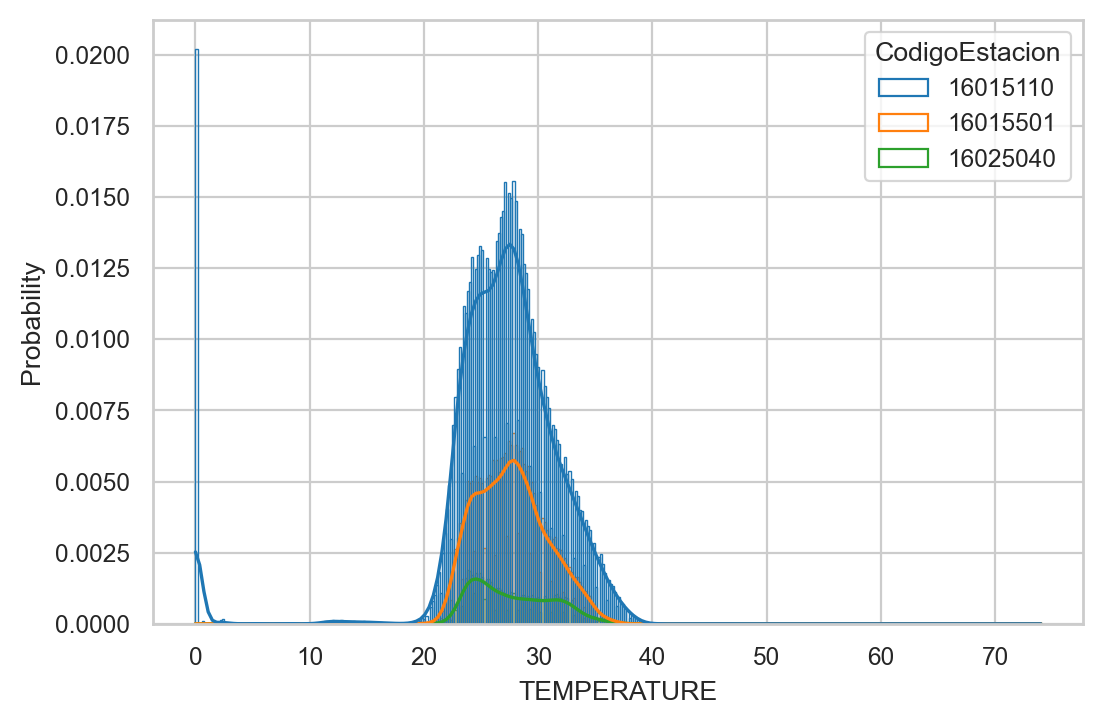

In [562]:
dfs = []
unique_stations = df_temp["CodigoEstacion"].unique()
fig = plt.figure(dpi=200)
sns.histplot(data = df_temp, x = "TEMPERATURE", hue = "CodigoEstacion",  palette = sns.color_palette("tab10")[0:len(unique_stations)], kde = True, fill = False, common_norm = True, stat = 'probability')
for i, codigoestacion in enumerate(unique_stations):
    df_temp_est =back = df_temp[df_temp["CodigoEstacion"]==codigoestacion].iloc[:,-1:]
    df_temp_est = prep.filter_entries_by_column_index_values(df_temp_est, standard_var_name, params["range_temp"][0],params["range_temp"][1]); # ELIMINACIÓN DE OUTLIERS EN LOS DATOS HORARIOS
    df_temp_est = prep.aggregate_data(df_temp_est, agg_type='daily', min_count = 12).sort_index()   # ELIMINACIÓN DE DÍAS SIN SUFICIENTES OBSERVACIONES
    columns = ["CodigoEstacion"] + list(df_temp_est.columns)
    df_temp_est["CodigoEstacion"] = codigoestacion
    df_temp_est = df_temp_est[columns]
    dfs.append(df_temp_est)
df_temp_daily = pd.concat(dfs, axis = 0)
df_temp_daily.describe()

In [563]:
fig = go.Figure()
for df_group in df_temp_daily.groupby("CodigoEstacion"):
    codigoestacion, df_gr = df_group
    df_gr = df_gr.resample('D').mean()
    plot_temp = go.Scatter(x=df_gr.index,
                y=df_gr[standard_var_name+"_MEAN"], name ="TEMP "+str(codigoestacion), mode = "lines", connectgaps= None)
    fig.add_trace(plot_temp)
    
layout = go.Layout(title="DAILY "+standard_var_name+" IN "+municipality_name,
                xaxis=dict(title='DATE'),
                yaxis=dict(title='TEMP'))
fig.update_layout(layout)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=40)
fig.show()

In [565]:
stations_corr =  df_temp_daily["CodigoEstacion"].unique()
pair_stations = list(itertools.combinations(stations_corr, 2))
dict_corr = {}
for pair in pair_stations:
    df_corr = df_temp_daily[df_temp_daily['CodigoEstacion'].isin(pair)]
    corr_table = pd.pivot_table(df_corr, values=['TEMPERATURE_AMAX','TEMPERATURE_AMIN',"TEMPERATURE_MEAN"],
                        columns=['CodigoEstacion'], index = df_corr.index)
    corr_table = corr_table.dropna(how = 'any', axis = 0)
    
    corr_table = corr_table.reindex(sorted(corr_table.columns), axis=1)
    dict_pair = {}
    dict_pair['TEMPERATURE_AMAX'] = corr_table.corr().iloc[0,1]
    dict_pair['TEMPERATURE_AMIN'] = corr_table.corr().iloc[2,3]
    dict_pair['TEMPERATURE_MEAN'] = corr_table.corr().iloc[4,5]
    dict_corr[pair] = dict_pair
all_corr_df = pd.DataFrame.from_dict(dict_corr)
all_corr_df.style.apply(prep.highlight_max, axis=1)
all_corr_df

16015110            16015501
                  16015501  16025040  16025040
TEMPERATURE_AMAX  0.952216  0.730532  0.757108
TEMPERATURE_AMIN  0.921035  0.603851  0.621895
TEMPERATURE_MEAN  0.965292  0.821657  0.847938

2. Combinación de estaciones por orden de prioridad: Aquí la idea es que una vez hecho el análisis de arriba seleccionemos los códigos de estaciones más relevantes para juntar.



In [566]:
# Manually set the priorities for the temperature stations as per the above results!
if len(params["stations_temp"]) == 0:
    stations_priority = [16015110, 16015501]
    params["stations_temp"] = stations_priority
    df_cities.loc[row_id,"stations_temp"] = repr(stations_priority)
    df_cities.to_csv("params.csv", index = False)
else:
    stations_priority = params["stations_temp"]

#stations_priority = [26085170,26055120] #Cali
#stations_priority = [29045190, 29004520   ] #Barranquilla
df_temp_daily = prep.combine_IDEAM_stations(df_temp_daily, stations_priority).sort_index()
df_temp_daily = df_temp_daily.resample('D').mean()

#df_temp_daily = df_temp_daily[df_temp_daily.index.date >= pd.to_datetime("2013/05/01")]

In [570]:
fig = go.Figure()
plot_temp = go.Scatter(x=df_temp_daily.index,
            y=df_temp_daily[standard_var_name+"_MEAN"], name ="CC", mode = "lines", marker_color = "red")
fig.add_trace(plot_temp)
layout = go.Layout(title="DAILY "+standard_var_name+" IN "+municipality_name,
                xaxis=dict(title='DATE'),
                yaxis=dict(title='°C'))
fig.update_layout(layout)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=40)
fig.show()

In [571]:
#dfa = df_temp_daily.groupby(df_temp_daily.index.year).mean().reset_index()
#dfa

# Workflow humedad

In [572]:
standard_var_name = "REL_HUMIDITY"
possible_hum_names = ["HRA2_AUT_60","Humedad del aire 2 mt"]
df_hum = prep.get_variable_IDEAM(df, possible_hum_names, standard_var_name).sort_index()
df_hum = prep.drop_duplicates_by_date_station(df_hum)

In [573]:
stations_hum = df_hum.drop_duplicates(subset=["CodigoEstacion"])["CodigoEstacion"].values
df_hum = df_hum[df_hum["CodigoEstacion"].isin(stations_hum)]
df_hum.head(3)

CodigoEstacion  REL_HUMIDITY
DATE                                             
2005-09-09 18:00:00        16015110          58.0
2005-09-09 19:00:00        16015110          60.0
2005-09-09 20:00:00        16015110          62.0

1. En este for se agregan por día los datos de cada estación. Es importante ajustar el min_count según la frecuencia de las mediciones. Yo tengo que intentar ajustar este código para que auto-detecte la frecuencia y se puedan combinar fácil series de distintas granularidades.

CodigoEstacion  REL_HUMIDITY_MEAN  REL_HUMIDITY_AMAX  REL_HUMIDITY_AMIN
count    7.304000e+03        7304.000000         7304.00000        7304.000000
mean     1.601583e+07          69.367291           85.10460          51.277519
std      2.390606e+03          10.645581           10.02612          11.691388
min      1.601511e+07          41.045455           50.00000          30.000000
25%      1.601511e+07          60.916667           80.00000          42.000000
50%      1.601511e+07          69.958333           87.00000          51.000000
75%      1.601550e+07          77.632775           93.00000          60.000000
max      1.602504e+07          98.875000           99.00000          98.000000

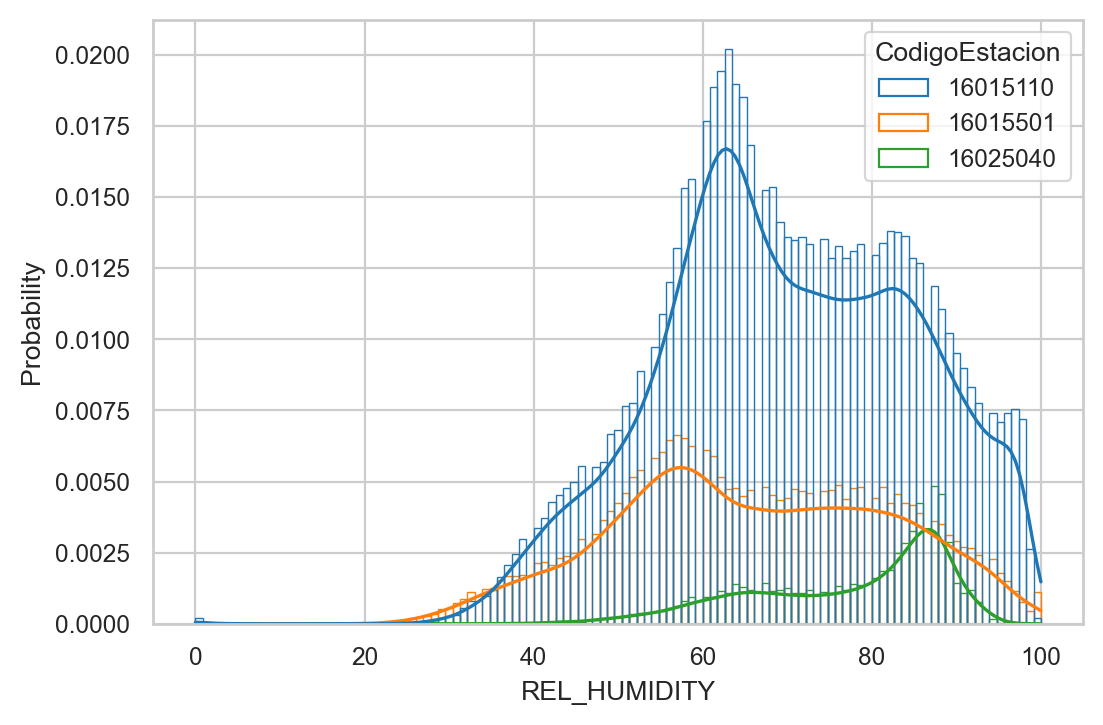

In [574]:
dfs = []
unique_stations = df_hum["CodigoEstacion"].unique()
fig = plt.figure(dpi=200)
sns.histplot(data = df_hum, x = "REL_HUMIDITY", hue = "CodigoEstacion",  palette = sns.color_palette("tab10")[0:len(unique_stations)], kde = True, fill = False, common_norm = True, stat = 'probability')
for codigoestacion in df_hum["CodigoEstacion"].unique():
    df_hum_est = df_hum[df_hum["CodigoEstacion"]==codigoestacion].iloc[:,-1:]
    df_hum_est = prep.filter_entries_by_column_index_values(df_hum_est, standard_var_name, params["range_hum"][0],params["range_hum"][1]) # ELIMINACIÓN DE OUTLIERS EN LOS DATOS HORARIOS
    df_hum_est = prep.aggregate_data(df_hum_est, agg_type='daily', min_count = 6).sort_index()   # ELIMINACIÓN DE DÍAS SIN SUFICIENTES OBSERVACIONES
    columns = ["CodigoEstacion"] + list(df_hum_est.columns)
    df_hum_est["CodigoEstacion"] = codigoestacion
    df_hum_est = df_hum_est[columns]
    dfs.append(df_hum_est)
df_hum_daily = pd.concat(dfs, axis = 0)
df_hum_daily.describe()

In [575]:
fig = go.Figure()
for df_group in df_hum_daily.groupby("CodigoEstacion"):
    codigoestacion, df_gr = df_group
    df_gr = df_gr.resample('D').mean()
    plot_temp = go.Scatter(x=df_gr.index,
                y=df_gr[standard_var_name+"_MEAN"], name ="HUMIDITY "+str(codigoestacion), mode = "lines", connectgaps= None)
    fig.add_trace(plot_temp)
    
layout = go.Layout(title="DAILY "+standard_var_name+" IN " + municipality_name,
                xaxis=dict(title='DATE'),
                yaxis=dict(title='HUMIDITY'))
fig.update_layout(layout)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=40)
fig.show()

In [576]:
stations_corr =  df_hum_daily["CodigoEstacion"].unique()
pair_stations = list(itertools.combinations(stations_corr, 2))
dict_corr = {}
for pair in pair_stations:
    df_corr = df_hum_daily[df_hum_daily['CodigoEstacion'].isin(pair)]
    corr_table = pd.pivot_table(df_corr, values=['REL_HUMIDITY_AMAX','REL_HUMIDITY_AMIN',"REL_HUMIDITY_MEAN"],
                        columns=['CodigoEstacion'], index = df_corr.index)
    corr_table = corr_table.dropna(how = 'any', axis = 0)
    
    corr_table = corr_table.reindex(sorted(corr_table.columns), axis=1)
    dict_pair = {}
    dict_pair['REL_HUMIDITY_AMAX'] = corr_table.corr().iloc[0,1]
    dict_pair['REL_HUMIDITY_AMIN'] = corr_table.corr().iloc[2,3]
    dict_pair['REL_HUMIDITY_MEAN'] = corr_table.corr().iloc[4,5]
    dict_corr[pair] = dict_pair
all_corr_df = pd.DataFrame.from_dict(dict_corr)
all_corr_df.style.apply(prep.highlight_max, axis=1)
all_corr_df

16015110            16015501
                   16015501  16025040  16025040
REL_HUMIDITY_AMAX  0.901927  0.450460  0.482541
REL_HUMIDITY_AMIN  0.932988  0.591638  0.590319
REL_HUMIDITY_MEAN  0.961802  0.735445  0.750313

2. Combinación de estaciones por orden de prioridad: Aquí la idea es que una vez hecho el análisis de arriba seleccionemos los códigos de estaciones más relevantes para juntar.



In [577]:
# Manually set the priorities for the temperature stations as per the above results!
#params["stations_hum"] = []
if len(params["stations_hum"]) == 0:
    stations_priority = [16015110, 16015501]
    params["stations_hum"] = stations_priority
    df_cities.loc[row_id,"stations_hum"] = repr(stations_priority)
    df_cities.to_csv("params.csv", index = False)
else:
    stations_priority = params["stations_hum"]
#stations_priority = [26055120,26085170] #Cali
df_hum_daily = prep.combine_IDEAM_stations(df_hum_daily, stations_priority).sort_index()
df_hum_daily = df_hum_daily.resample('D').mean()
#df_hum_daily = df_hum_daily[df_hum_daily.index.date >= pd.to_datetime("2013/04/15")]

In [578]:
fig = go.Figure()
plot_hum = go.Scatter(x=df_hum_daily.index,
            y=df_hum_daily[standard_var_name+"_MEAN"], name ="HUM", mode = "lines")
fig.add_trace(plot_hum)
layout = go.Layout(title="DAILY "+standard_var_name+" IN "+municipality_name,
                xaxis=dict(title='DATE'),
                yaxis=dict(title='%'))
fig.update_layout(layout)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=40)
fig.show()

# Workflow datos del NIÑO

In [579]:
#Variable SSTOI

df_sstoi = pd.read_table(path_base+'src_general/sstoi.txt',delim_whitespace=True) 
df_sstoi.columns = ['YEAR', 'MONTH', 'SST1+2', 'ANOM1+2', 'SST3', 'ANOM3', 'SST4', 'ANOM4',
       'SST3.4', 'ANOM3.4']
df_sstoi = df_sstoi[['YEAR', 'MONTH', 'SST1+2', 'SST3', 'SST4',
       'SST3.4']]
df_sstoi.index = pd.to_datetime(df_sstoi["YEAR"].map(str)+"/"+df_sstoi["MONTH"].map(str)+"/01")
del(df_sstoi["YEAR"])
del(df_sstoi["MONTH"])
df_sstoi_daily = df_sstoi.resample('M').ffill().resample('D').bfill()
df_sstoi_daily.tail(1)

SST1+2   SST3   SST4  SST3.4
2021-05-31   23.78  26.76  28.82   27.62

In [581]:
#Variable ONI
def read_oni_file(path):
    file = open(path)
    lines = file.readlines()
    file.close()
    lines = lines[1:-8]
    meses = [str(i).zfill(2) for i in range(1,13)] 
    datos_mensuales = [] 
    for line in lines:
        line = line.split("  ")
        line = [el.replace(" ","").replace("\n","") for el in line]
        ano = line[0]
        for i,el in enumerate(line[1:]):
            datos_mensuales.append([ano,meses[i],el])
    df_oni = pd.DataFrame.from_records(datos_mensuales)
    columns = ["YEAR","MONTH","ONI"]
    df_oni.columns = columns
    df_oni["ONI"] = df_oni["ONI"].apply(lambda x: x.split("-99.9")[0])
    df_oni["ONI"] = df_oni["ONI"].apply(lambda x: float(x))
    return df_oni

df_oni = read_oni_file(path_base+'src_general/oni.txt')
df_oni.index = pd.to_datetime(df_oni["YEAR"].map(str)+"/"+df_oni["MONTH"].map(str)+"/01")
del(df_oni["YEAR"])
del(df_oni["MONTH"])
df_oni_daily = df_oni.resample('M').ffill().resample('D').bfill()
df_oni_daily.tail(1)

ONI
2021-04-30 -0.67

In [582]:
def read_meiv2_file(path):
    file = open(path)
    lines = file.readlines()
    file.close()
    lines = lines[1:-4]

    meses = [str(i).zfill(2) for i in range(1,13)] 
    datos_mensuales = [] 
    for line in lines:
        line = line.split()
        line = [el.replace("","").replace("\n","") for el in line]
        ano = line[0]
        for i,el in enumerate(line[1:]):
            datos_mensuales.append([ano,meses[i],el])
    df_meiv2 = pd.DataFrame.from_records(datos_mensuales)
    columns = ["YEAR","MONTH","MEI"]
    df_meiv2.columns = columns
    df_meiv2 = df_meiv2.replace("-999.00",np.nan).dropna()
    df_meiv2["MEI"] = df_meiv2["MEI"].apply(lambda x: float(x))
    return df_meiv2

df_meiv2 = read_meiv2_file(path_base+'src_general/meiv2.txt')
df_meiv2.index = pd.to_datetime(df_meiv2["YEAR"].map(str)+"/"+df_meiv2["MONTH"].map(str)+"/01")
del(df_meiv2["YEAR"])
del(df_meiv2["MONTH"])
df_meiv2_daily = df_meiv2.resample('M').ffill().resample('D').bfill()
df_meiv2_daily.tail(1)

MEI
2021-05-31 -1.06

In [583]:
def read_car_file(path):
    file = open(path)
    lines = file.readlines()
    file.close()
    lines = lines[1:-6]

    meses = [str(i).zfill(2) for i in range(1,13)] 
    datos_mensuales = [] 
    for line in lines:
        line = line.split()
        line = [el.replace("","").replace("\n","") for el in line]
        ano = line[0]
        for i,el in enumerate(line[1:]):
            datos_mensuales.append([ano,meses[i],el])
    df_car = pd.DataFrame.from_records(datos_mensuales)
    columns = ["YEAR","MONTH","CAR"]
    df_car.columns = columns
    df_car = df_car.replace("-99.99",np.nan).dropna()
    df_car["CAR"] = df_car["CAR"].apply(lambda x: float(x))
    return df_car

df_car = read_car_file(path_base+'src_general/car.txt')
df_car.index = pd.to_datetime(df_car["YEAR"].map(str)+"/"+df_car["MONTH"].map(str)+"/01")
del(df_car["YEAR"])
del(df_car["MONTH"])
df_car_daily = df_car.resample('M').ffill().resample('D').bfill()
df_car_daily.tail(1)

CAR
2020-02-29  0.43

In [584]:
def read_nta_file(path):
    file = open(path)
    lines = file.readlines()
    file.close()
    lines = lines[1:-6]

    meses = [str(i).zfill(2) for i in range(1,13)] 
    datos_mensuales = [] 
    for line in lines:
        line = line.split()
        line = [el.replace("","").replace("\n","") for el in line]
        ano = line[0]
        for i,el in enumerate(line[1:]):
            datos_mensuales.append([ano,meses[i],el])
    df_nta = pd.DataFrame.from_records(datos_mensuales)
    columns = ["YEAR","MONTH","NTA"]
    df_nta.columns = columns
    df_nta = df_nta.replace("-99.99",np.nan).dropna()
    df_nta["NTA"] = df_nta["NTA"].apply(lambda x: float(x))
    return df_nta

df_nta = read_nta_file(path_base+'src_general/nta.txt')
df_nta.index = pd.to_datetime(df_nta["YEAR"].map(str)+"/"+df_nta["MONTH"].map(str)+"/01")
del(df_nta["YEAR"])
del(df_nta["MONTH"])
df_nta_daily = df_nta.resample('M').ffill().resample('D').bfill()
df_nta_daily.head(1)

NTA
1950-02-28 -0.49

In [585]:
def read_tni_file(path):
    file = open(path)
    lines = file.readlines()
    file.close()
    lines = lines[1:-10]
    meses = [str(i).zfill(2) for i in range(1,13)] 
    datos_mensuales = [] 
    for line in lines:
        line = line.split()
        #line = [el.replace("","").replace("\n","") for el in line]
        ano = line[0]
        for i,el in enumerate(line[1:]):
            datos_mensuales.append([ano,meses[i],el])
    df_tni = pd.DataFrame.from_records(datos_mensuales)
    columns = ["YEAR","MONTH","TNI"]
    df_tni.columns = columns
    df_tni = df_tni.replace("-99.990",np.nan).dropna()
    df_tni["TNI"] = df_tni["TNI"].apply(lambda x: float(x))
    #df_tni["TNI"] = df_tni["TNI"].apply(lambda x: x.split("-99.")[0])
    return df_tni

df_tni = read_tni_file(path_base+'src_general/tni.txt')
df_tni.index = pd.to_datetime(df_tni["YEAR"].map(str)+"/"+df_tni["MONTH"].map(str)+"/01")
del(df_tni["YEAR"])
del(df_tni["MONTH"])
df_tni_daily = df_tni.resample('M').ffill().resample('D').bfill()
df_tni_daily.tail(1)

TNI
2021-03-31 -0.007

# SIVIGILA calendar workflow

En esta sección se combinan todos los dataframes diarios y luego se hace remuestreo por semana.

In [586]:
df_daily = prep.get_sivigila_calendar()
df_daily = df_daily[(df_daily.index>pd.to_datetime(params["starting_date"]))&(df_daily.index<pd.to_datetime("2020-02-29"))]

In [587]:
df_daily = pd.merge(df_daily, df_prec_daily,  how = "left",  left_index=True, right_index=True)
df_daily = pd.merge(df_daily, df_temp_daily,  how = "left",  left_index=True, right_index=True)
df_daily = pd.merge(df_daily, df_hum_daily,  how = "left",   left_index=True, right_index=True)
df_daily = pd.merge(df_daily, df_meiv2_daily,  how = "left", left_index=True, right_index=True)
df_daily = pd.merge(df_daily, df_oni_daily,  how = "left",   left_index=True, right_index=True)
df_daily = pd.merge(df_daily, df_sstoi_daily,  how = "left", left_index=True, right_index=True)
df_daily = pd.merge(df_daily, df_tni_daily,  how = "left",   left_index=True, right_index=True)
df_daily = pd.merge(df_daily, df_car_daily,  how = "left",   left_index=True, right_index=True)
df_daily = pd.merge(df_daily, df_nta_daily,  how = "left",   left_index=True, right_index=True)

# Revisión inicial de datos faltantes

<AxesSubplot:>

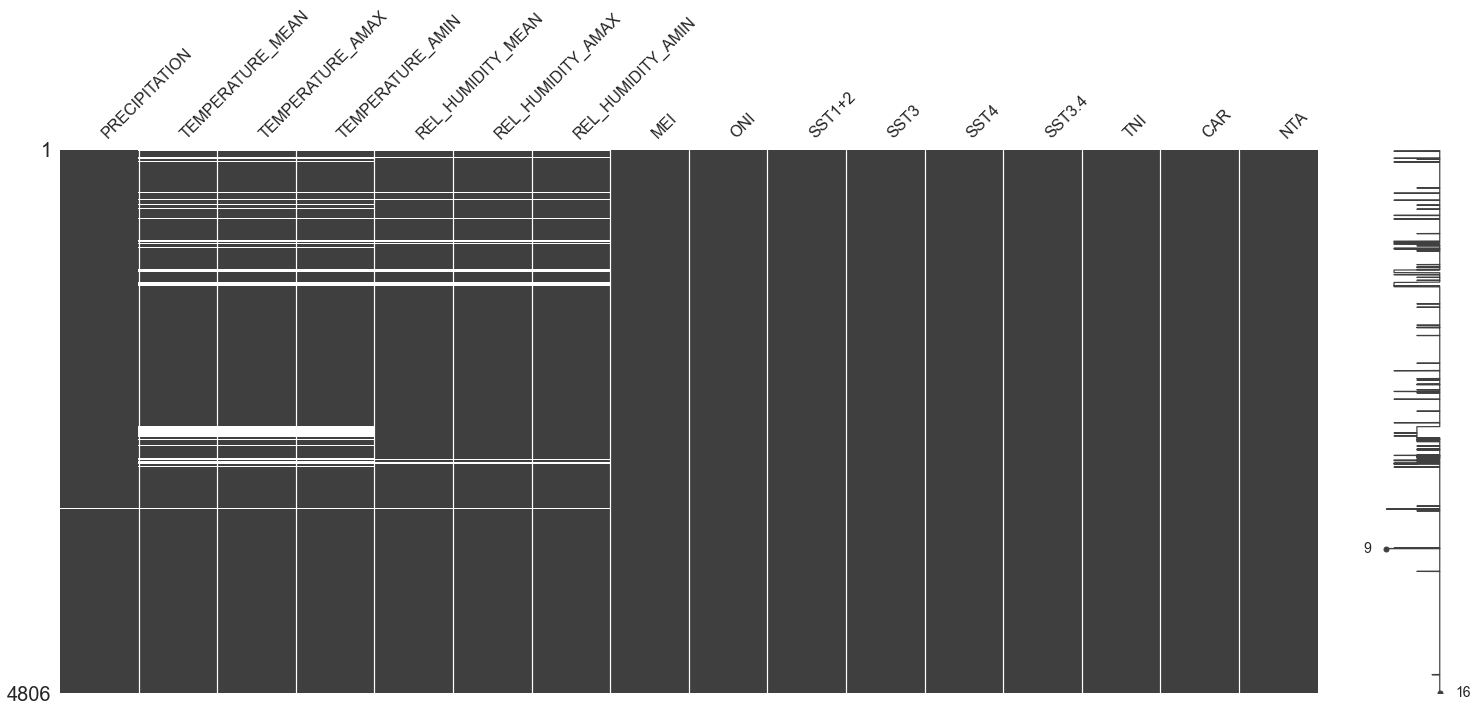

In [588]:
%matplotlib inline
msno.matrix(df_daily.iloc[:,2:])


-----------------

In [357]:
#df_daily_interp = prep.imput_data_with_sklearn_imputer(df_daily)
#df_daily_interp = prep.imput_data_with_closest_and_mean(df_daily)
#df_daily_interp = df_daily.interpolate(method="time")
"""fig = go.Figure()
plot_temp = go.Scatter(x=df_daily.index,
            y=df_daily["TEMPERATURE_MEAN"], name ="CC", mode = "lines")
fig.add_trace(plot_temp)
layout = go.Layout(title="DAILY "+"TEMPERATURE"+" IN "+municipality_name,
                xaxis=dict(title='DATE'),
                yaxis=dict(title='°C'))
fig.update_layout(layout)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=40)
fig.show()
""";

In [589]:
#df_daily_interp["TEMPERATURE_RANGE"] = df_daily_interp["TEMPERATURE_AMAX"]  - df_daily_interp["TEMPERATURE_AMIN"] 
threshold_dry = 0.1 # Characteristics of consecutive dry days variations in China (2016)
df_daily["DRY_DAYS"] = df_daily["PRECIPITATION"].apply(lambda x: 1 if x < threshold_dry else 0)
df_daily.head()

ANO SEMANA  PRECIPITATION  TEMPERATURE_MEAN  TEMPERATURE_AMAX  \
FECHA                                                                        
2007-01-02  2007     01            0.0         27.179167              34.6   
2007-01-03  2007     01            0.0         26.583333              31.4   
2007-01-04  2007     01            0.0         26.516667              34.6   
2007-01-05  2007     01            0.0         26.586364              32.9   
2007-01-06  2007     01            0.0         26.575000              32.7   

            TEMPERATURE_AMIN  REL_HUMIDITY_MEAN  REL_HUMIDITY_AMAX  \
FECHA                                                                
2007-01-02              21.8          66.208333               88.0   
2007-01-03              20.9          60.166667               87.0   
2007-01-04              21.0          65.666667               84.0   
2007-01-05              20.6          70.227273               91.0   
2007-01-06              20.9          72.125000               93.0   

            REL_HUMIDITY_AMIN   MEI   ONI  SST1+2  SST3   SST4  SST3.4    TNI  \
FECHA                                                                           
2007-01-02               43.0  0.62  0.66   24.99  26.5  28.93   27.26 -1.594   
2007-01-03               43.0  0.62  0.66   24.99  26.5  28.93   27.26 -1.594   
2007-01-04               42.0  0.62  0.66   24.99  26.5  28.93   27.26 -1.594   
2007-01-05               49.0  0.62  0.66   24.99  26.5  28.93   27.26 -1.594   
2007-01-06               49.0  0.62  0.66   24.99  26.5  28.93   27.26 -1.594   

            CAR  NTA  DRY_DAYS  
FECHA                           
2007-01-02  0.3  0.4         1  
2007-01-03  0.3  0.4         1  
2007-01-04  0.3  0.4         1  
2007-01-05  0.3  0.4         1  
2007-01-06  0.3  0.4         1

In [590]:
df_weekly_sums = df_daily[["ANO","SEMANA","PRECIPITATION","DRY_DAYS"]].groupby(["ANO","SEMANA"]).sum().reset_index()
df_weekly_maxes = df_daily[["ANO","SEMANA","TEMPERATURE_AMAX","REL_HUMIDITY_AMAX"]].groupby(["ANO","SEMANA"]).max().reset_index()
df_weekly_mins = df_daily[["ANO","SEMANA","TEMPERATURE_AMIN","REL_HUMIDITY_AMIN"]].groupby(["ANO","SEMANA"]).min().reset_index()
df_weekly_means = df_daily[['ANO', 'SEMANA', 'TEMPERATURE_MEAN','REL_HUMIDITY_MEAN', 'MEI','ONI', 'SST1+2', 'SST3', 'SST4', 'SST3.4', 'TNI', 'CAR','NTA']].groupby(["ANO","SEMANA"]).mean().reset_index()

In [591]:
df_weekly = pd.merge(df_weekly_sums,df_weekly_maxes, how = "inner", on = ["ANO","SEMANA"] )
df_weekly = pd.merge(df_weekly,df_weekly_mins, how = "inner", on = ["ANO","SEMANA"] )
df_weekly = pd.merge(df_weekly,df_weekly_means, how = "inner", on = ["ANO","SEMANA"] )
df_weekly.head()

ANO SEMANA  PRECIPITATION  DRY_DAYS  TEMPERATURE_AMAX  REL_HUMIDITY_AMAX  \
0  2007     01            0.0         5              34.6               93.0   
1  2007     02            0.0         7              31.7               92.0   
2  2007     03            3.4         2              32.3               97.0   
3  2007     04            0.0         7              35.9               94.0   
4  2007     05            0.0         7              37.8               90.0   

   TEMPERATURE_AMIN  REL_HUMIDITY_AMIN  TEMPERATURE_MEAN  REL_HUMIDITY_MEAN  \
0              20.6               42.0         26.688106          66.878788   
1              22.1               55.0         26.217799          77.790425   
2              22.1               55.0         24.695109          84.744565   
3              21.3               39.0         27.101527          73.249482   
4              21.3               30.0         28.098007          62.185455   

        MEI       ONI     SST1+2       SST3       SST4     SST3.4       TNI  \
0  0.620000  0.660000  24.990000  26.500000  28.930000  27.260000 -1.594000   
1  0.620000  0.660000  24.990000  26.500000  28.930000  27.260000 -1.594000   
2  0.620000  0.660000  24.990000  26.500000  28.930000  27.260000 -1.594000   
3  0.620000  0.660000  24.990000  26.500000  28.930000  27.260000 -1.594000   
4  0.521429  0.471429  25.525714  26.478571  28.797143  27.067143 -1.696857   

        CAR       NTA  
0  0.300000  0.400000  
1  0.300000  0.400000  
2  0.300000  0.400000  
3  0.300000  0.400000  
4  0.325714  0.408571

# Dengue cases workflow

In [592]:
df_dengue = pd.read_csv(path_base+"prepared_dengue/dengue_weekly_2007_2020.csv", dtype={'COD_MUNICIPIO':str})
df_dengue = df_dengue[df_dengue["COD_MUNICIPIO"]==cod_municipio]
df_dengue["FECHA"] = pd.to_datetime(df_dengue["FECHA"])
df_dengue = df_dengue[(df_dengue["FECHA"]>=pd.to_datetime(params["starting_date"]))&(df_dengue["FECHA"]<=pd.to_datetime("2020/02/29"))] #ajustando los casos de dengue para que queden hasta abril.
df_weekly["SEMANA"] = df_weekly["SEMANA"].astype('int')
df_weekly["ANO"] = df_weekly["ANO"].astype('int')
df_weekly = pd.merge(df_weekly,df_dengue, how = "inner", on = ["ANO","SEMANA"] )

# Elevation and population workflow

In [593]:
df_population = pd.read_csv(path_base+"src_general/data_per_year.csv", dtype={"COD_MUNICIPIO":str})
df_population["COD_MUNICIPIO"] = df_population["COD_MUNICIPIO"].apply(lambda x: str(x).zfill(5))
df_population = df_population[df_population["COD_MUNICIPIO"]==cod_municipio]
df_population.head(2)

ANO COD_MUNICIPIO  COD_DPTO  DENGUE  DENGUE GRAVE  \
737   2006         54001        54       0             0   
1828  2007         54001        54    2400           546   

      MORTALIDAD POR DENGUE  POBLACION  
737                       0   593766.0  
1828                      6   599905.0

In [594]:
df_municipios = pd.read_csv(path_base+"src_general/departments.csv")
df_municipios["COD_MUNICIPIO"] = df_municipios["COD_MUNICIPIO"].apply(lambda x: str(x).zfill(5))
df_municipios = df_municipios[df_municipios["COD_MUNICIPIO"]==cod_municipio]
df_weekly = pd.merge(df_weekly, df_population[["ANO","POBLACION"]], how = "left", on = "ANO")

In [595]:
df_weekly = df_weekly.set_index(["FECHA","COD_DPTO","COD_MUNICIPIO","POBLACION"])
df_weekly = df_weekly.reset_index()
df_weekly = df_weekly.set_index("FECHA")

In [596]:
fig = go.Figure()
plot_temp = go.Scatter(x=df_weekly.index,
            y=df_weekly["TEMPERATURE_MEAN"], name ="CC", mode = "lines")
fig.add_trace(plot_temp)
layout = go.Layout(title="WEEKLY "+"TEMPERATURE"+" IN "+municipality_name,
                xaxis=dict(title='DATE'),
                yaxis=dict(title='°C'))
fig.update_layout(layout)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=40)
fig.show()

# Missing data imputation

<AxesSubplot:>

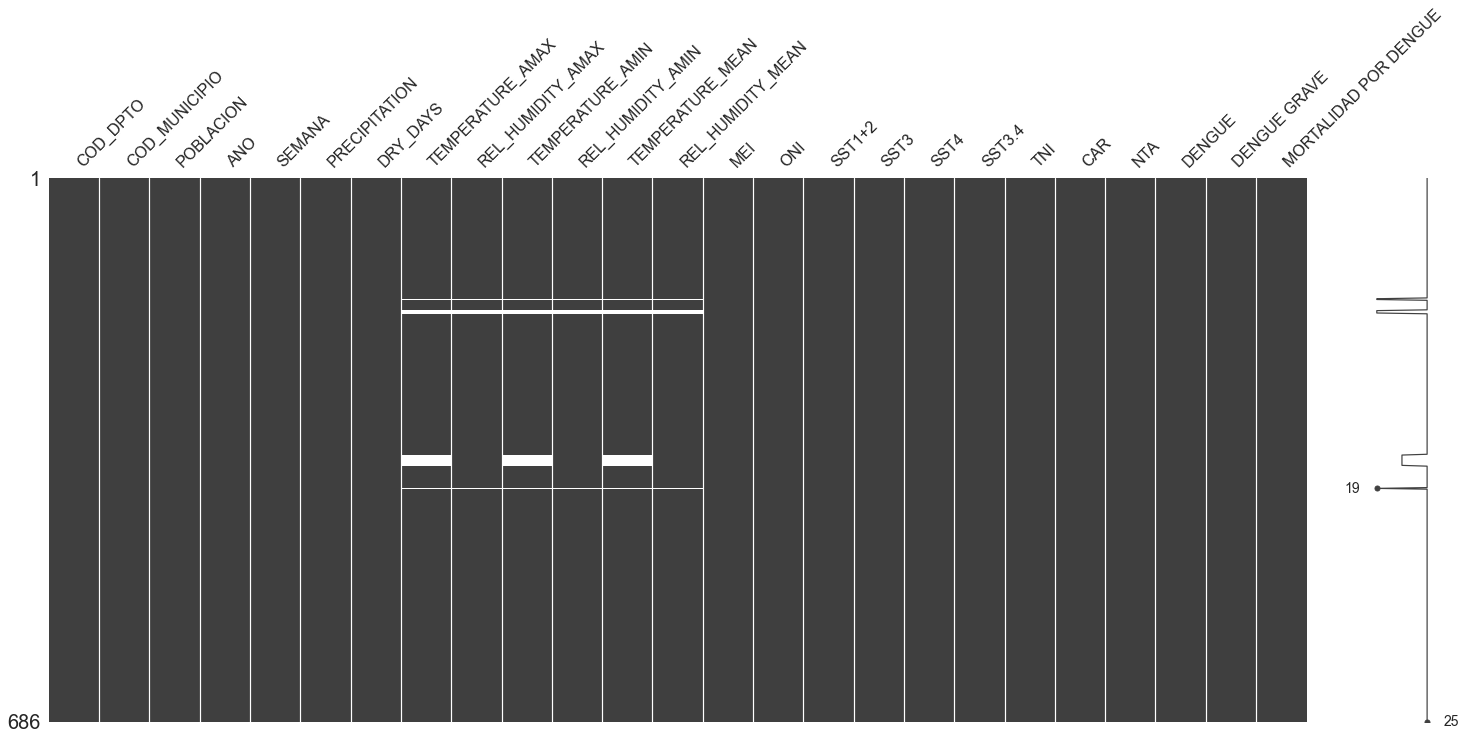

In [597]:
msno.matrix(df_weekly)

In [598]:
vars_to_imput = [
            "PRECIPITATION",
            "TEMPERATURE_MEAN",
            "TEMPERATURE_AMAX",
            "TEMPERATURE_AMIN",
            "REL_HUMIDITY_MEAN",
            "REL_HUMIDITY_AMAX",
            "REL_HUMIDITY_AMIN",
        ]

In [599]:
df_weekly_interp_model = prep.imput_data_with_sklearn_imputer(df_weekly)
df_weekly_interp = df_weekly.interpolate("nearest")
df_weekly_interp_means = prep.imput_with_mean_of_week(df_weekly)
df_weekly_imput_windowed = prep.imput_with_wind_mean_of_week(df_weekly)
df_weekly_final = df_weekly.copy()
df_weekly_final[vars_to_imput] = (df_weekly_interp_model[vars_to_imput]*0.1+df_weekly_imput_windowed[vars_to_imput]*0.9+df_weekly_interp[vars_to_imput]*0.)

In [600]:
df_weekly_final["TEMPERATURE_RANGE"] = df_weekly_final["TEMPERATURE_AMAX"] - df_weekly_final["TEMPERATURE_AMIN"]
df_weekly_final = df_weekly_final[['COD_DPTO', 'COD_MUNICIPIO', 'POBLACION', 'ANO', 'SEMANA',
    'PRECIPITATION', 'DRY_DAYS', 'TEMPERATURE_AMAX', 'REL_HUMIDITY_AMAX',
    'TEMPERATURE_AMIN', 'TEMPERATURE_RANGE', 'REL_HUMIDITY_AMIN', 'TEMPERATURE_MEAN',
    'REL_HUMIDITY_MEAN', 'MEI', 'ONI', 'SST1+2', 'SST3', 'SST4', 'SST3.4',
    'TNI', 'CAR', 'NTA', 'DENGUE', 'DENGUE GRAVE', 'MORTALIDAD POR DENGUE']]

In [601]:
fig = go.Figure()
plot_temp = go.Scatter(x=df_weekly_final.index,
            y=df_weekly_final["TEMPERATURE_MEAN"], name ="FILLED", mode = "lines")
plot_temp_nofill = go.Scatter(x=df_weekly.index,
            y=df_weekly["TEMPERATURE_MEAN"], name ="ORIGINAL", mode = "lines")
fig.add_trace(plot_temp)
fig.add_trace(plot_temp_nofill)
layout = go.Layout(title="WEEKLY "+"TEMPERATURE"+" IN "+municipality_name,
                xaxis=dict(title='DATE'),
                yaxis=dict(title='°C'))
fig.update_layout(layout)
fig.update_yaxes(nticks=20)
fig.update_xaxes(nticks=40)
fig.show()

In [602]:
df_weekly_final.to_csv(path_base+f"prepared_per_city/cucuta_consolidado_{params['starting_date'][0:4]}_2020.csv",index = True)

In [603]:
df_weekly_final.isna().sum()

COD_DPTO                 0
COD_MUNICIPIO            0
POBLACION                0
ANO                      0
SEMANA                   0
PRECIPITATION            0
DRY_DAYS                 0
TEMPERATURE_AMAX         0
REL_HUMIDITY_AMAX        0
TEMPERATURE_AMIN         0
TEMPERATURE_RANGE        0
REL_HUMIDITY_AMIN        0
TEMPERATURE_MEAN         0
REL_HUMIDITY_MEAN        0
MEI                      0
ONI                      0
SST1+2                   0
SST3                     0
SST4                     0
SST3.4                   0
TNI                      0
CAR                      0
NTA                      0
DENGUE                   0
DENGUE GRAVE             0
MORTALIDAD POR DENGUE    0
dtype: int64